In [2]:
! pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -------------------------------

C:\Users\sagni\AppData\Local\Temp\ipykernel_25220\1552491953.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range("2022-01-01", periods=24, freq="M")
C:\Users\sagni\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\sagni\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\sagni\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\sagni\AppData\Local\Temp\ipykernel_25220\1552491953.py:

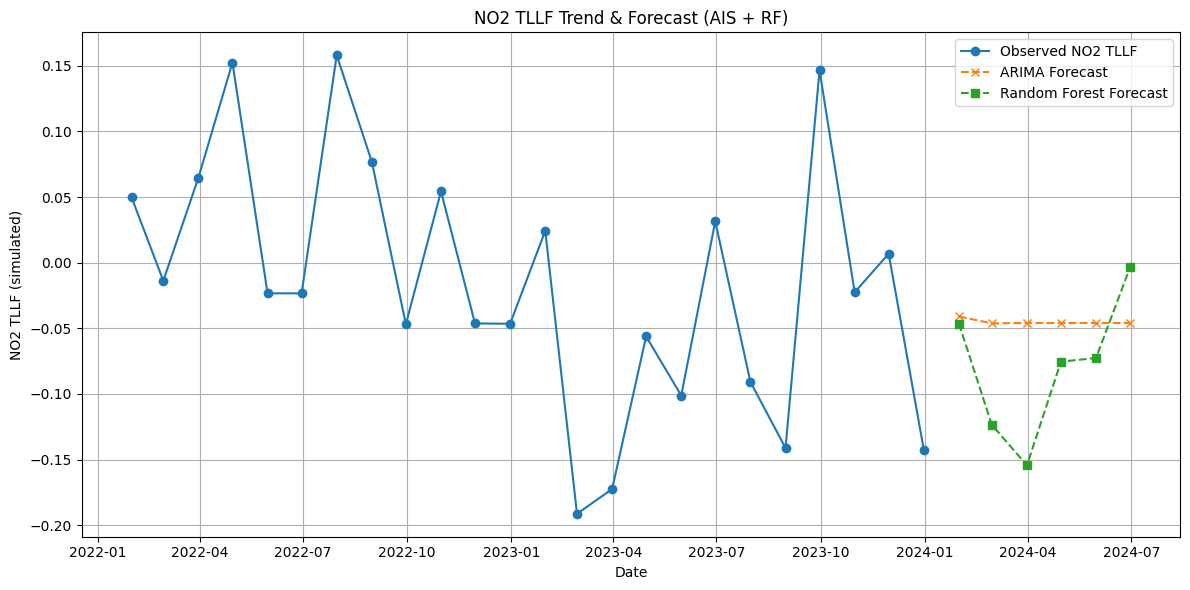

✅ Forecast plot saved to:
C:\Users\sagni\Downloads\Pollution controller\NO2_TLLF_Trend_Forecast.png


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import os

# === Set the path to the NO2 TLLF TIFF file ===
tif_path = r"C:\Users\sagni\Downloads\Pollution controller\NO2_TLLF_Jan2023.tif"

# === Load the TIF image ===
with rasterio.open(tif_path) as src:
    img = src.read(1)
    img = np.where(img == src.nodata, np.nan, img)

# === Compute average value (mean NO2 TLLF) over time (if stack) or space ===
mean_values = np.nanmean(img)

# === Simulate monthly mean values if it's a single TIF ===
# In reality, you'd extract multiple TIFs over months. We'll simulate 24 months.
np.random.seed(42)
months = pd.date_range("2022-01-01", periods=24, freq="M")
no2_values = np.random.normal(loc=mean_values, scale=0.1, size=24)  # Add noise
data = pd.DataFrame({"Date": months, "NO2_TLLF": no2_values})
data.set_index("Date", inplace=True)

# === Train ARIMA Model for Forecasting ===
model_arima = ARIMA(data["NO2_TLLF"], order=(1,1,1))
arima_result = model_arima.fit()

forecast_arima = arima_result.forecast(steps=6)
forecast_arima.index = pd.date_range(data.index[-1] + pd.Timedelta(days=30), periods=6, freq="M")

# === Prepare data for RF ===
data["Month"] = data.index.month
data["Year"] = data.index.year

X = data[["Year", "Month"]]
y = data["NO2_TLLF"]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# === Predict next 6 months with RF ===
future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=30), periods=6, freq="M")
future_df = pd.DataFrame({
    "Year": future_dates.year,
    "Month": future_dates.month
})
rf_pred = rf.predict(future_df)

# === Plot both forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["NO2_TLLF"], label="Observed NO2 TLLF", marker='o')
plt.plot(forecast_arima.index, forecast_arima, label="ARIMA Forecast", linestyle="--", marker='x')
plt.plot(future_dates, rf_pred, label="Random Forest Forecast", linestyle="--", marker='s')
plt.xlabel("Date")
plt.ylabel("NO2 TLLF (simulated)")
plt.title("NO2 TLLF Trend & Forecast (AIS + RF)")
plt.legend()
plt.grid()
plt.tight_layout()

# === Save the plot ===
output_path = os.path.join(os.path.dirname(tif_path), "NO2_TLLF_Trend_Forecast.png")
plt.savefig(output_path)
plt.show()

print(f"✅ Forecast plot saved to:\n{output_path}")


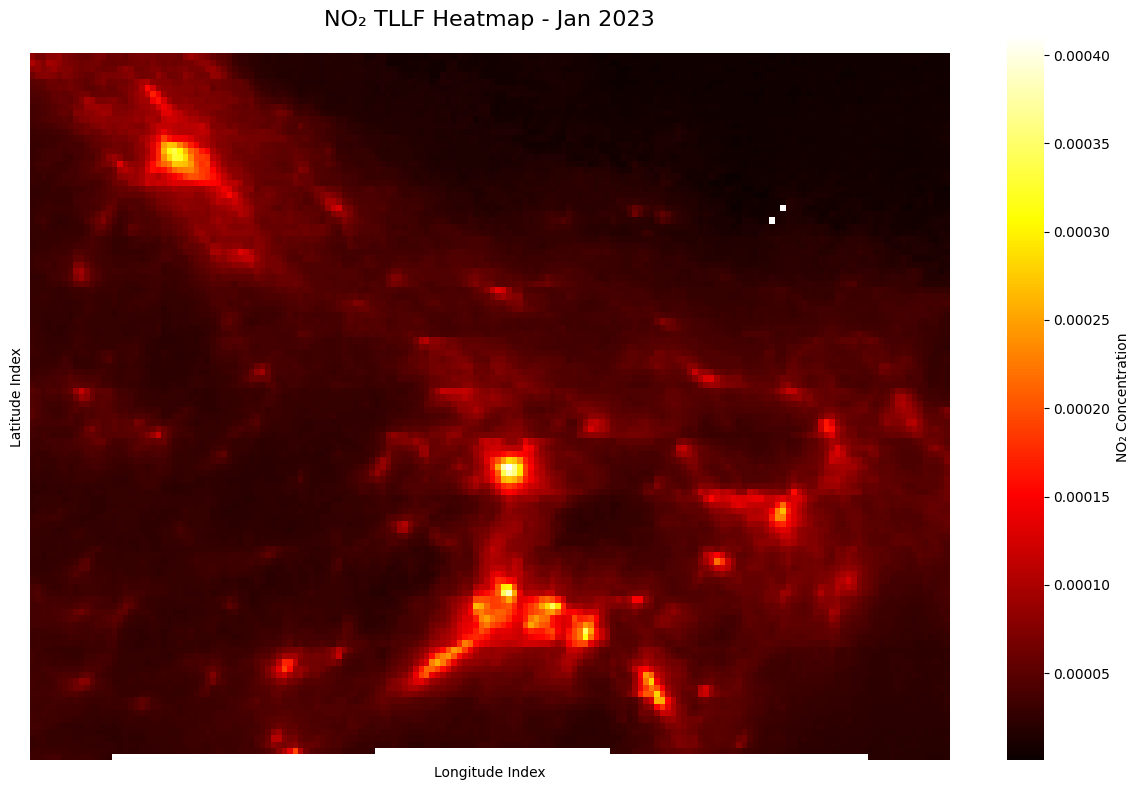

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the TIF file
tif_path = r"C:\Users\sagni\Downloads\Pollution controller\NO2_TLLF_Jan2023.tif"

with rasterio.open(tif_path) as src:
    data = src.read(1)  # Read the first band
    data = np.where(data == src.nodata, np.nan, data)  # Handle nodata

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data, cmap='hot', cbar_kws={'label': 'NO₂ Concentration'}, xticklabels=False, yticklabels=False)

plt.title("NO₂ TLLF Heatmap - Jan 2023", fontsize=16)
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.tight_layout()

# Save and show
plt.savefig(r"C:\Users\sagni\Downloads\Pollution controller\NO2_TLLF_Heatmap_Jan2023.png", dpi=300)
plt.show()
